# Optimisation de la gestion des données de la boutique BottleNeck

# Sommaire

* [1. Importation des données](#1)
* [2. Nettoyage des données](#2)
    * [2.1. Erreurs de type et valeurs manquantes](#2_1)
    * [2.2. Doublons](#2_2)
        * [2.2.1. Dataframe 'erp'](#2_2_1)
        * [2.2.2. Dataframe 'données_web'](#2_2_2)
        * [2.2.3. Dataframe 'liaison'](#2_2_3)
* [3. Rapprochement des deux exports 'erp' et 'web'](#3)
    * [3.1. Jointures pour rapprocher les deux exports](#3_1)
        * [3.1.1. Jointures](#3_1_1)
        * [3.1.2. Vérification des jointures](#3_1_2)
    * [3.2. Calcul du chiffre d'affaires par produit et chiffre d'affaires total](#3_2)
* [4. Etude des outliers](#4)
    * [4.1. Calcul du Z-score des prix](#4_1)
    * [4.2. Calcul de l'écart interquartile des prix](#4_2)
    * [4.3. Vérification des outliers](#4_3)
* [5. Conclusion](#5)

## 1. Importation des données <a class="anchor" id="1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

erp = pd.read_excel('erp.xlsx')
liaison = pd.read_excel('liaison.xlsx')
web = pd.read_excel('web.xlsx')

In [3]:
erp.head()

,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock


In [4]:
liaison.head()

,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815


In [5]:
web.head()

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


## 2. Nettoyage des données <a class="anchor" id="2"></a>

### 2.1. Erreurs de type et valeurs manquantes <a class="anchor" id="2_1"></a>

In [6]:
erp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      825 non-null    int64  
 1   onsale_web      825 non-null    int64  
 2   price           825 non-null    float64
 3   stock_quantity  825 non-null    int64  
 4   stock_status    825 non-null    object 
dtypes: float64(1), int64(3), object(1)
memory usage: 32.4+ KB


In [7]:
# Changement de type pour 'product_id' en object
erp['product_id'] = erp['product_id'].astype(object)

In [8]:
liaison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  825 non-null    int64 
 1   id_web      734 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


In [9]:
# Changement de type pour 'product_id' en object
liaison['product_id'] = liaison['product_id'].astype(object)

# Renommage de la colonne 'id_web' en 'sku'
liaison.rename(columns={'id_web':'sku'}, inplace = True)

In [10]:
web.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sku                    1428 non-null   object        
 1   virtual                1513 non-null   int64         
 2   downloadable           1513 non-null   int64         
 3   rating_count           1513 non-null   int64         
 4   average_rating         1430 non-null   float64       
 5   total_sales            1430 non-null   float64       
 6   tax_status             716 non-null    object        
 7   tax_class              0 non-null      float64       
 8   post_author            1430 non-null   float64       
 9   post_date              1430 non-null   datetime64[ns]
 10  post_date_gmt          1430 non-null   datetime64[ns]
 11  post_content           0 non-null      float64       
 12  post_title             1430 non-null   object        
 13  pos

In [11]:
# Vérifions les lignes avec les sku vides 
web_sku_nan = web.loc[web['sku'].isna()]
web_sku_nan.describe()

,virtual,downloadable,rating_count,average_rating,total_sales,tax_class,post_author,post_content,post_password,post_content_filtered,post_parent,menu_order,comment_count
count,85.0,85.0,85.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0
mean,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,NaN,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,NaN,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,NaN,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,NaN,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,NaN,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,NaN,0.0,0.0,0.0


In [12]:
# Regardons les lignes qui ne contiennent pas de données vides ou valeurs nulles
web_sku_nan.loc[web_sku_nan['post_author'].notna()]

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
470,NaN,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-07-31 12:07:23,...,pierre-jean-villa-cote-rotie-fongeant-2017,2019-11-02 13:24:15,2019-11-02 12:24:15,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
471,NaN,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-08-08 11:23:43,...,pierre-jean-villa-condrieu-suspendu-2018,2019-11-02 13:24:01,2019-11-02 12:24:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


Il y a deux produits sans Id 'sku' : "pierre-jean-villa-cote-rotie-fongeant-2017" et "pierre-jean-villa-condrieu-suspendu-2018".

In [13]:
# Nouveau dataframe où les lignes sans 'sku' sont supprimées
données_web = web.dropna(subset=['sku'])

### 2.2. Doublons <a class="anchor" id="2_2"></a>

#### 2.2.1. Dataframe 'erp' <a class="anchor" id="2_2_1"></a>

In [14]:
# Regardons la taille de ce dataframe
erp.shape

(825, 5)

In [15]:
# Le nombre de 'product_id' unique
erp['product_id'].nunique()

825

Aucun doublon dans 'erp'.

#### 2.2.2. Dataframe 'données_web' <a class="anchor" id="2_2_2"></a>

In [16]:
# Regardons la taille de ce dataframe 
données_web.shape

(1428, 28)

In [17]:
# Le nombre de 'sku' unique
données_web['sku'].nunique()

714

Il n'y a que 714 sku unique dans le fichier pour 1428 lignes. Il faut donc supprimer les doublons. 

In [18]:
# Gardons seulement les colonnes qui seront utiles pour la suite de l'étude dans notre copie du dataframe 'web'
données_web = données_web[['sku', 'total_sales', 'post_title', 'post_type']]

#Vérifions que les 1428 lignes sont vraiment des doublons en vérifiant les informations dans les autres colonnes
données_web.groupby('sku').count().describe()

,total_sales,post_title,post_type
count,714.0,714.0,714.0
mean,2.0,2.0,2.0
std,0.0,0.0,0.0
min,2.0,2.0,2.0
25%,2.0,2.0,2.0
50%,2.0,2.0,2.0
75%,2.0,2.0,2.0
max,2.0,2.0,2.0


Les lignes sont en effet en double. On peut donc les supprimer. 

In [19]:
# Suppression des lignes en double
données_web.drop_duplicates(subset=['sku'], inplace=True, ignore_index=True)

print(f"Le nombre d'ID unique de la colonne 'sku' est de {données_web['sku'].nunique()} pour un nombre total de {len(données_web['sku'])} lignes.")

Le nombre d'ID unique de la colonne 'sku' est de 714 pour un nombre total de 714 lignes.


#### 2.2.3. Dataframe 'liaison' <a class="anchor" id="2_2_3"></a>

In [20]:
# Regardons les lignes en doublons dans 'liaison'
liaison.loc[liaison[['product_id', 'sku']].duplicated(keep=False), :]

,product_id,sku


Aucun doublons dans 'liaison'.

## 3. Rapprochement des deux exports 'erp' et 'web' <a class="anchor" id="3"></a>

### 3.1. Jointures pour rapprocher les deux exports <a class="anchor" id="3_1"></a>

#### 3.1.1. Jointures <a class="anchor" id="3_1_1"></a>

In [21]:
# Jointure entre le dataframe 'erp' et 'liaison'
erp_liaison = pd.merge(erp, liaison, how='left', on='product_id')

# Jointure entre le dataframe 'données_web' et l'export 'erp'
erp_web = pd.merge(données_web, erp_liaison, how='left', on='sku')

#### 3.1.2. Vérification des jointures <a class="anchor" id="3_1_2"></a>

In [22]:
# Vérification de la jointure entre le dataframe 'erp' et 'liaison'
erp_liaison.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 825 entries, 0 to 824
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      825 non-null    object 
 1   onsale_web      825 non-null    int64  
 2   price           825 non-null    float64
 3   stock_quantity  825 non-null    int64  
 4   stock_status    825 non-null    object 
 5   sku             734 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 45.1+ KB


Nous retrouvons bien les 825 product_id et les 734 sku. 

In [23]:
# Vérification de la jointure entre le dataframe 'données_web' et l'export 'erp'
erp_web.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 713
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sku             714 non-null    object 
 1   total_sales     714 non-null    float64
 2   post_title      714 non-null    object 
 3   post_type       714 non-null    object 
 4   product_id      714 non-null    object 
 5   onsale_web      714 non-null    int64  
 6   price           714 non-null    float64
 7   stock_quantity  714 non-null    int64  
 8   stock_status    714 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 55.8+ KB


Nous avons bien une correspondance pour chacune des lignes de 'données_web'.

In [24]:
# Vérification des 'match' et 'non-match' sur la jointure, utilisons une jointure 'outer' pour avoir toutes les lignes (à gauche et à droite)
verif = pd.merge(données_web, erp_liaison, how='outer', on='sku', indicator=True)

# Nombre de 'match' à la fois à gauche et à droite
nb_match_verif = verif.loc[verif['_merge'] == 'both']['sku'].nunique()

# Liste des 'product_id' et 'sku' non présents dans 'erp_web'
verif = verif.loc[verif['_merge'] == 'right_only'][['product_id', 'sku']]
nb_product_id_verif = verif['product_id'].nunique()
nb_sku_verif = verif['sku'].nunique()

print(f"Il y a {nb_product_id_verif} product_id dont {nb_sku_verif} avec une correspondance sku qui n'ont pas jointé avec les données du fichier web.\nIl y a donc {nb_product_id_verif-nb_sku_verif} product_id sans sku correspondant.\nPour autant, {nb_match_verif} clés ont jointé avec succés.")

Il y a 111 product_id dont 20 avec une correspondance sku qui n'ont pas jointé avec les données du fichier web.
Il y a donc 91 product_id sans sku correspondant.
Pour autant, 714 clés ont jointé avec succés.


### 3.2. Calcul du chiffre d'affaires par produit et chiffre d'affaires total <a class="anchor" id="3_2"></a>

In [25]:
# Rajout d'une colonne 'Chiffre d'affaires' pour avoir le CA par produit
erp_web["Chiffre d'affaires"] = erp_web['price'] * erp_web['total_sales']

# Calcul du CA total
ca_total = erp_web["Chiffre d'affaires"].sum()
print(f"Le chiffre d'affaires total est de {ca_total}€.")

Le chiffre d'affaires total est de 70568.6€.


## 4. Etude des outliers <a class="anchor" id="4"></a>

In [26]:
# Calculons la médianne de la variable prix
med = erp_web['price'].median()
print(f'Le prix médian des bouteilles est de {med}€.')

Le prix médian des bouteilles est de 23.55€.


In [27]:
# Calculons la moyenne de la variable prix
m = erp_web['price'].mean()
print(f'Le prix moyen des bouteilles est de {round(m, 2)}€.')

Le prix moyen des bouteilles est de 32.49€.


Il y a une différence notable entre le prix médian et le prix moyen. Cela nous indique une asymétrie positive au niveau de la variable prix. Nous allons donc chercher les valeurs qui viennent influer "positivement" sur la moyenne en calculant le Z-score pour chacun des prix des produits.

### 4.1. Calcul du Z-score des prix <a class="anchor" id="4_1"></a>

In [28]:
# Calculons l'écart-type de la variable prix
s = erp_web['price'].std()

# Rajoutons le Z-score comme colonne du dataframe 'erp_web'
erp_web['Z-score'] = (erp_web['price'] - m)/s

Le Z-score nous indique à combien d'écart-types se trouve le prix par rapport à la moyenne. Considérons qu'un Z-score égal à 2 signifie que la valeur est très éloignée de la moyenne et donc que ce prix est un 'outlier'.

In [29]:
# Il faut isoler les outliers dans un Dataframe 'outliers'
outliers = erp_web.loc[(erp_web['Z-score'] >=2) | (erp_web['Z-score'] <= -2)]

# Puis isoler les autres valeurs dans un autre Dataframe 'non_outliers'
non_outliers = erp_web.drop(erp_web[(erp_web['Z-score'] >= 2) | (erp_web['Z-score'] <= -2)].index)

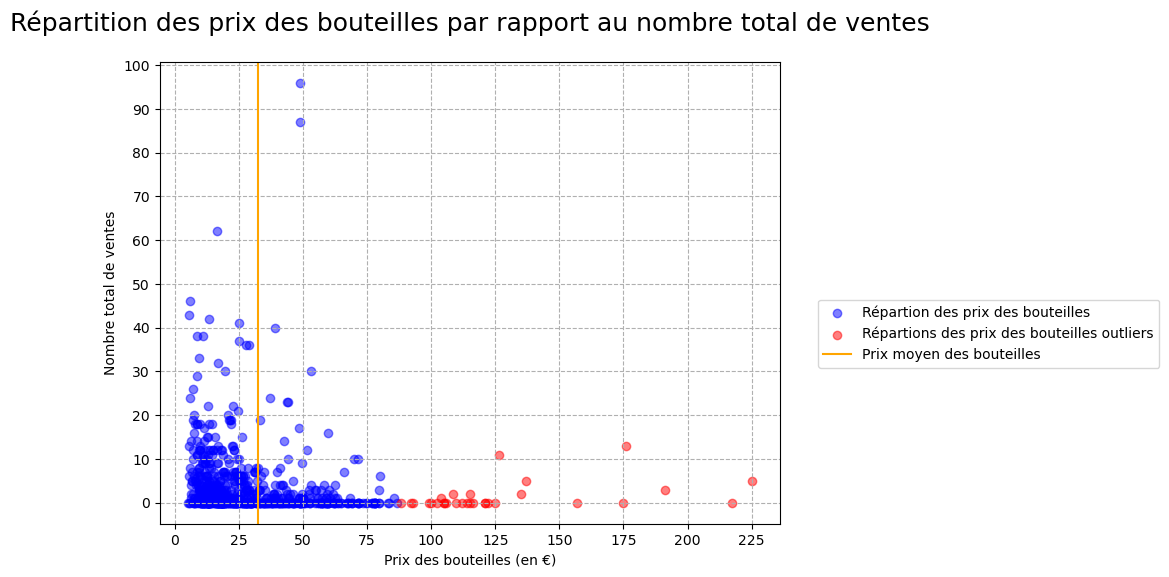

In [30]:
# Repésentons la répartition des prix des bouteilles sur un nuage de points afin de mieux visualiser
plt.figure(figsize=(8,6))
plt.scatter(non_outliers['price'], non_outliers['total_sales'], color = 'blue', label = 'Répartion des prix des bouteilles', alpha=0.5)
plt.scatter(outliers['price'], outliers['total_sales'], color= 'red', label= 'Répartions des prix des bouteilles outliers', alpha=0.5)
plt.axvline(m, color='orange', label = 'Prix moyen des bouteilles')
plt.title('Répartition des prix des bouteilles par rapport au nombre total de ventes', fontsize=18, y=1.05)
plt.xlabel('Prix des bouteilles (en €)', fontsize=10)
plt.ylabel('Nombre total de ventes', fontsize=10)
plt.xticks(np.arange(0,250,25))
plt.yticks(np.arange(0,110,10))
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left')
plt.grid(linestyle = 'dashed')
plt.show()

Notons qu'aucune corrélation entre le prix des bouteilles et le nombre de ventes n'apparait sur ce graphique.

In [31]:
# Affichons les outliers dans un tableau
outliers = outliers.sort_values('Z-score', ascending=False)
outliers

,sku,total_sales,post_title,post_type,product_id,onsale_web,price,stock_quantity,stock_status,Chiffre d'affaires,Z-score
200,15940,5.0,Champagne Egly-Ouriet Grand Cru Millésimé 2008,product,4352,1,225.0,0,outofstock,1125.0,6.922087
426,14581,0.0,David Duband Charmes-Chambertin Grand Cru 2014,product,5001,1,217.5,20,instock,0.0,6.652405
587,14983,3.0,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,product,5892,1,191.3,10,instock,573.9,5.710315
219,3510,13.0,Cognac Frapin VIP XO,product,4402,1,176.0,8,instock,2288.0,5.160164
553,15185,0.0,Camille Giroud Clos de Vougeot 2016,product,5767,1,175.0,12,instock,0.0,5.124206
222,7819,0.0,Cognac Frapin Château de Fontpinot 1989 20 Ans...,product,4406,1,157.0,3,instock,0.0,4.476969
382,14220,5.0,Domaine Des Croix Corton Charlemagne Grand Cru...,product,4904,1,137.0,13,instock,685.0,3.757817
642,14923,2.0,Champagne Gosset Célébris Vintage 2007,product,6126,1,135.0,10,instock,270.0,3.685902
202,12589,11.0,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,product,4355,1,126.5,2,instock,1391.5,3.380262
511,14915,0.0,Domaine Weinbach Gewurztraminer Grand Cru Furs...,product,5612,1,124.8,12,instock,0.0,3.319134


In [32]:
print(f"Nous pouvons trouver {len(outliers)} outliers avec la méthode du Z-score.")

Nous pouvons trouver 30 outliers avec la méthode du Z-score.


### 4.2. Calcul de l'écart interquartile des prix <a class="anchor" id="4_2"></a>

In [33]:
describe_erp_web = erp_web.describe()
describe_erp_web

,total_sales,onsale_web,price,stock_quantity,Chiffre d'affaires,Z-score
count,714.000000,714.0,714.000000,714.000000,714.000000,7.140000e+02
mean,4.012605,1.0,32.493137,28.746499,98.835574,9.951579e-18
std,8.518183,0.0,27.810525,48.012608,307.685071,1.000000e+00
min,0.000000,1.0,5.200000,0.000000,0.000000,-9.813960e-01
25%,0.000000,1.0,14.100000,2.000000,0.000000,-6.613733e-01
50%,1.000000,1.0,23.550000,12.000000,15.250000,-3.215738e-01
75%,4.000000,1.0,42.175000,35.000000,91.150000,3.481366e-01
max,96.000000,1.0,225.000000,578.000000,4704.000000,6.922087e+00


On peut voir ci-dessus que l'on a 75% des prix qui se situent en dessous de 42.17€. Le maximum étant de 225€, il y a une grande disparité entre le prix maximum et le reste des prix. 

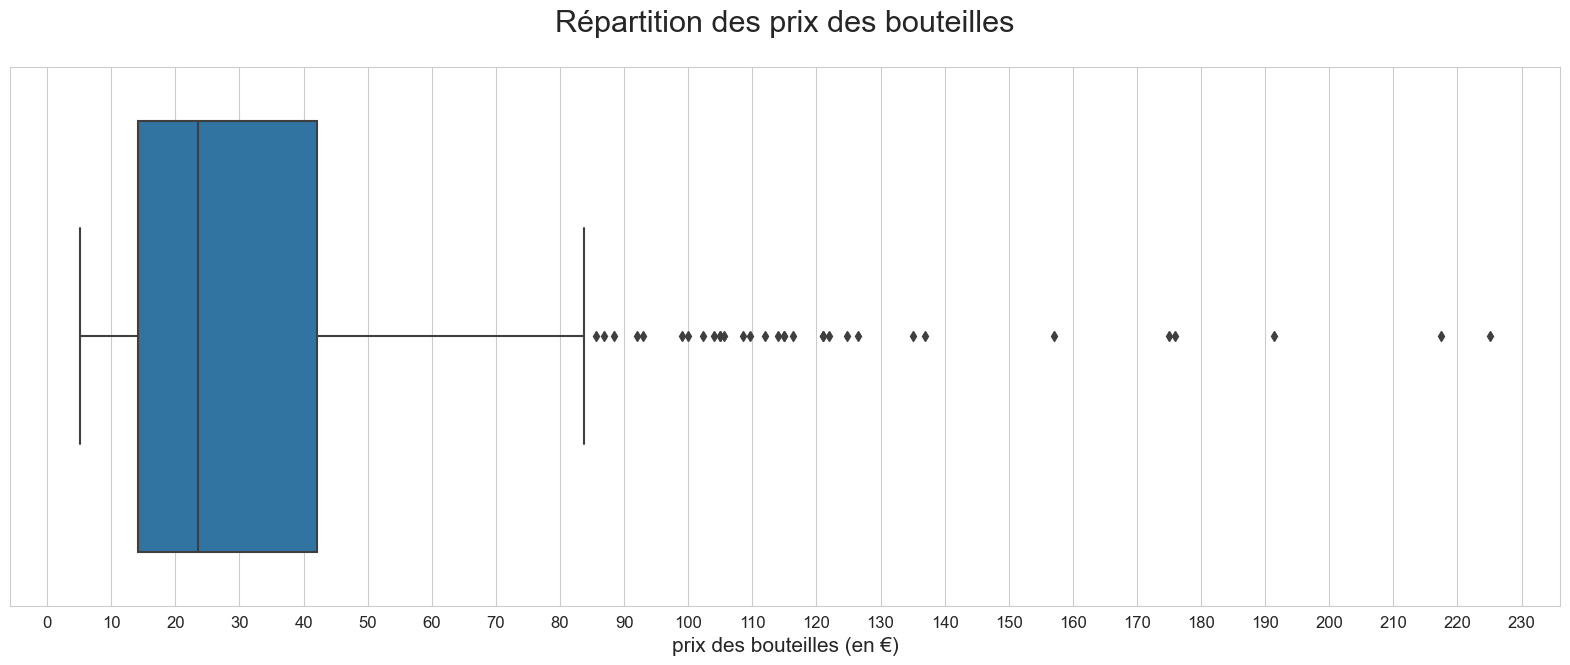

In [34]:
# Utilisons une boxplot pour visualiser cela
plt.figure(figsize=(20,7))
sns.set_style('whitegrid')
sns.boxplot(x=erp_web['price'])
plt.title('Répartition des prix des bouteilles', fontsize=22, y=1.05)
plt.xlabel('prix des bouteilles (en €)', fontsize=15)
plt.xticks(np.arange(0,240,10))
plt.tick_params(labelsize=12)
plt.show()

In [35]:
# Calculons Q1 et Q3
Q1 = describe_erp_web.loc['25%', 'price']
Q3 = describe_erp_web.loc['75%', 'price']

# Calculons ensuite l'écart intercartile 'IQR'
IQR = Q3 - Q1

print(f"L'écart interquartile des prix est de {round(IQR,2)}€.")

L'écart interquartile des prix est de 28.08€.


In [36]:
# Déterminons les bornes inférieure et supérieure de l'écart interquartile
borne_inférieure = Q1-1.5*IQR
borne_supérieure = Q3+1.5*IQR

#Identifions les outliers avec cette méthode
outliers_IQR = erp_web[(erp_web['price'] < borne_inférieure) | (erp_web['price'] > borne_supérieure)]
outliers_IQR.sort_values('price', ascending=False)

,sku,total_sales,post_title,post_type,product_id,onsale_web,price,stock_quantity,stock_status,Chiffre d'affaires,Z-score
200,15940,5.0,Champagne Egly-Ouriet Grand Cru Millésimé 2008,product,4352,1,225.0,0,outofstock,1125.0,6.922087
426,14581,0.0,David Duband Charmes-Chambertin Grand Cru 2014,product,5001,1,217.5,20,instock,0.0,6.652405
587,14983,3.0,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,product,5892,1,191.3,10,instock,573.9,5.710315
219,3510,13.0,Cognac Frapin VIP XO,product,4402,1,176.0,8,instock,2288.0,5.160164
553,15185,0.0,Camille Giroud Clos de Vougeot 2016,product,5767,1,175.0,12,instock,0.0,5.124206
222,7819,0.0,Cognac Frapin Château de Fontpinot 1989 20 Ans...,product,4406,1,157.0,3,instock,0.0,4.476969
382,14220,5.0,Domaine Des Croix Corton Charlemagne Grand Cru...,product,4904,1,137.0,13,instock,685.0,3.757817
642,14923,2.0,Champagne Gosset Célébris Vintage 2007,product,6126,1,135.0,10,instock,270.0,3.685902
202,12589,11.0,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,product,4355,1,126.5,2,instock,1391.5,3.380262
511,14915,0.0,Domaine Weinbach Gewurztraminer Grand Cru Furs...,product,5612,1,124.8,12,instock,0.0,3.319134


In [37]:
print(f"Nous pouvons trouver {len(outliers_IQR)} outliers avec la méthode de l'écart interquartile.")

Nous pouvons trouver 32 outliers avec la méthode de l'écart interquartile.


Nous garderons donc les outliers de la méthode de l'écart interquartille pour pouvoir les étudier car plus nombreux.

### 4.3. Vérification des outliers <a class="anchor" id="4_3"></a>

In [38]:
# Regardons plus en détails ces outliers en regardant si ces bouteilles sont vendus
produits_vendus = outliers_IQR[outliers_IQR['total_sales'] != 0].groupby('sku')['total_sales'].count()
print(f"Le nombre d'outliers qui ont été vendus est de {len(produits_vendus)}, pour {len(outliers_IQR)} outliers totaux. \nIl y a donc {len(outliers_IQR)-len(produits_vendus)} outliers qui n'ont jamais été achetés.")

Le nombre d'outliers qui ont été vendus est de 10, pour 32 outliers totaux. 
Il y a donc 22 outliers qui n'ont jamais été achetés.


In [39]:
# Sur les 22 outliers non vendus, regardons combien sont en rupture de stock.
produits_non_vendus = outliers_IQR[(outliers_IQR['total_sales'] > 0) & (outliers_IQR['stock_status'] == 'outofstock')].groupby('sku')['total_sales'].count()
print(f"Sur les 22 produits qui n'ont jamais été achetés, {len(produits_non_vendus)} sont en rupture de stock. Il est donc normal que ces bouteilles ne générent pas de chiffre d'affaires.")

Sur les 22 produits qui n'ont jamais été achetés, 2 sont en rupture de stock. Il est donc normal que ces bouteilles ne générent pas de chiffre d'affaires.


In [40]:
# Regardons le nombre de ventes des bouteilles 'outliers' par rapport au nombre total de ventes
nb_ventes = erp_web['total_sales'].sum()
nb_ventes_outliers = outliers_IQR['total_sales'].sum()
proportion_ventes_outliers = round((nb_ventes_outliers/nb_ventes)*100,2)
print(f'Ces bouteilles représentent {proportion_ventes_outliers}% des ventes totales de bouteilles.')

Ces bouteilles représentent 1.57% des ventes totales de bouteilles.


In [41]:
# Calculons le chiffre d'affaires généré par les 10 bouteilles qui ont été vendues
ca_outliers = outliers_IQR["Chiffre d'affaires"].sum()
print(f"Le chiffre d'affaires généré par ces bouteilles est de {ca_outliers}€, ce qui représente {round((ca_outliers/ca_total)*100,2)}% du chiffre d'affaires total.")

Le chiffre d'affaires généré par ces bouteilles est de 6970.0€, ce qui représente 9.88% du chiffre d'affaires total.


## 5. Conclusion <a class="anchor" id="5"></a>

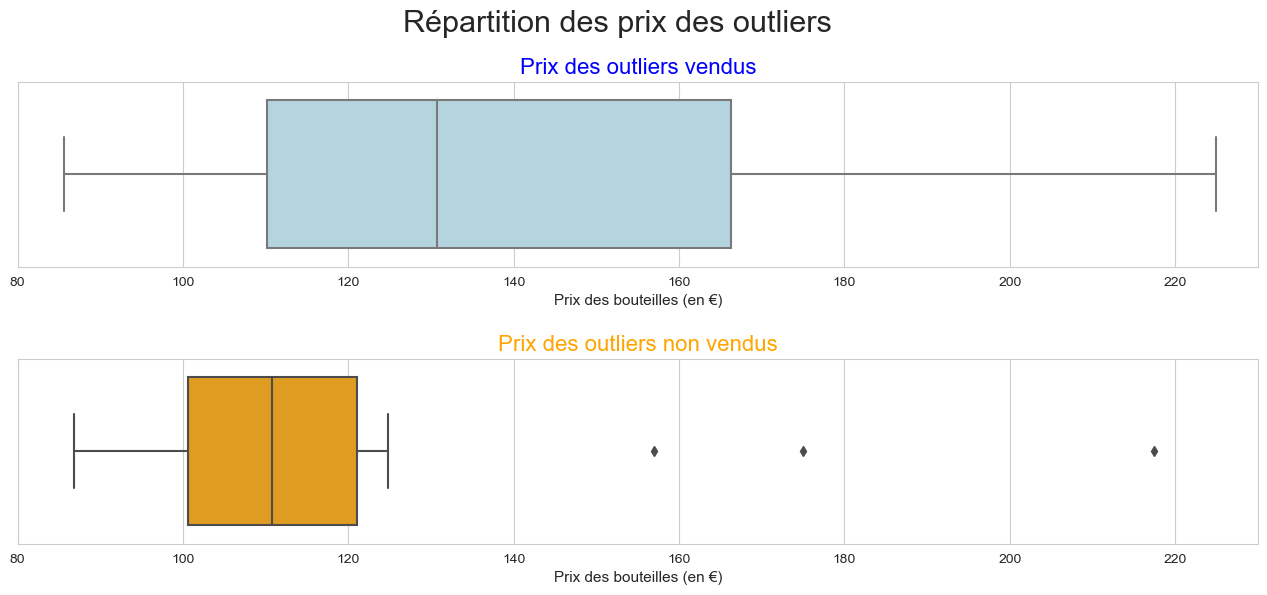

In [42]:
# Création de 2 dataframes pour différencier les outliers vendus des outliers non-vendus
outliers_vendus = outliers_IQR.loc[outliers_IQR['total_sales'] > 0]
outliers_non_vendus = outliers_IQR.loc[outliers_IQR['total_sales'] == 0]

# Regardons l'étendue des prix des outliers vendus par rapport à ceux qui ne sont pas vendus
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 6))
sns.boxplot(x=outliers_vendus['price'], ax=ax1, color='lightblue')
sns.boxplot(x=outliers_non_vendus['price'], ax=ax2, color='orange')
sns.set_style('whitegrid')
plt.subplots_adjust(hspace=0.5)
ax1.set_xlim(80, 230)
ax2.set_xlim(80, 230)
ax1.set_title("Prix des outliers vendus", fontsize=16, color='blue')
ax2.set_title("Prix des outliers non vendus", fontsize=16, color='orange')
ax1.set_xlabel("Prix des bouteilles (en €)", fontsize=11)
ax2.set_xlabel("Prix des bouteilles (en €)", fontsize=11)
plt.suptitle('Répartition des prix des outliers', fontsize=22, y=1)
plt.show()

Les prix des outliers non vendus se situent dans la fourchette des prix des outliers vendus. Nous pouvons donc dire que les prix "élevés" de ces bouteilles ne semblent pas incohérents. 
De plus, le chiffre d'affaires de ces bouteilles représente quasiment 10% du chiffre d'affaires total, donc supprimé ces outliers reviendrait à supprimer cette partie du chiffre d'affaires. 